# Task 4 — Insights and Recommendations (Bank Mobile App Reviews)

**Goal:** Derive insights from sentiment and themes, visualize results, and recommend app improvements.

## Checklist (Rubric Alignment)
- **Insights**: 2+ drivers and 2+ pain points per bank (with evidence)
- **Comparison**: cross-bank comparison (e.g., CBE vs BOA)
- **Recommendations**: 2+ improvements per bank
- **Visualization**: 3–5 plots (Matplotlib/Seaborn)
- **Ethics**: review bias/limitations note
- **Git**: work on `task-4` branch; commit visuals/report; PR merge

**Outputs produced by this notebook**
- `reports/task4/task4_report.md` (Markdown report)
- `reports/task4/figures/*.png` (plots)
- `reports/task4/*.csv` (evidence tables)


In [1]:
from __future__ import annotations

from pathlib import Path
import os, re, textwrap
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine, text

pd.set_option('display.max_colwidth', 120)
sns.set_theme(style='whitegrid')


## 0) Configuration
Tune thresholds:
- `MIN_N`: min reviews per (bank, theme)
- `TOP_K`: number of drivers/pains per bank


In [2]:
MIN_N = 15
TOP_K = 3
OUT_DIR = Path('reports/task4')
FIG_DIR = OUT_DIR / 'figures'
OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print('Writing outputs to:', OUT_DIR.resolve())


Writing outputs to: D:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\notebooks\reports\task4


## 1) Connect to PostgreSQL and load data
Supports `DATABASE_URL` or `DB_HOST, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD`.

**Schema used**
- `banks(bank_id, bank_name, app_name)`
- `reviews(review_id, bank_id, review_text, rating, review_date, source, sentiment_label, sentiment_score, theme_primary, review_hash)`


In [3]:
def db_engine_from_env():
    db_url = os.getenv('DATABASE_URL')
    if db_url:
        return create_engine(db_url)
    host = os.getenv('DB_HOST', 'localhost')
    port = os.getenv('DB_PORT', '5432')
    name = os.getenv('DB_NAME')
    user = os.getenv('DB_USER')
    pwd = os.getenv('DB_PASSWORD')
    if not all([name, user, pwd]):
        raise RuntimeError('Set DATABASE_URL or DB_NAME/DB_USER/DB_PASSWORD (and optionally DB_HOST/DB_PORT).')
    return create_engine(f'postgresql+psycopg2://{user}:{pwd}@{host}:{port}/{name}')

SQL_REVIEWS = '''
SELECT
    b.bank_name,
    b.app_name,
    r.review_id,
    r.bank_id,
    r.review_text,
    r.rating,
    r.review_date,
    r.source,
    r.sentiment_label,
    r.sentiment_score,
    r.theme_primary,
    r.review_hash
FROM reviews r
JOIN banks b ON b.bank_id = r.bank_id
WHERE r.review_text IS NOT NULL
'''

engine = db_engine_from_env()
with engine.connect() as conn:
    df = pd.read_sql(text(SQL_REVIEWS), conn)

df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['sentiment_label'] = df['sentiment_label'].fillna('UNKNOWN').astype(str).str.upper()
df['theme_primary'] = df['theme_primary'].fillna('UNKNOWN').astype(str)
df['source'] = df['source'].fillna('UNKNOWN').astype(str)
df['bank_name'] = df['bank_name'].astype(str)

print('Rows:', len(df))
df.head()


Rows: 1786


,bank_name,app_name,review_id,bank_id,review_text,rating,review_date,source,sentiment_label,sentiment_score,theme_primary,review_hash
0,CBE,CBE Mobile Banking,1,5,"Great App!!! Some times it may become busy,but that is not Problem of the company that type of problem is network ca...",5,2026-02-17,Google Play,POSITIVE,0.986176,OTHER,f005209ca725fff6df7c995255098546de088ea05446ffcfef60e1948ac22b7f
1,CBE,CBE Mobile Banking,2,5,it's nice app for me,5,2026-02-17,Google Play,POSITIVE,0.999668,OTHER,8bda7fa9a399eed1d327dd0dd4d4ba214d9eb52724a755101bca342633597d3b
2,CBE,CBE Mobile Banking,3,5,I like it very much.Thank you,5,2026-02-17,Google Play,POSITIVE,0.999746,OTHER,e89e4a6bde9f6244a5547fc414b51389f3978ab05b00ba1ff795f84c01f9959f
3,CBE,CBE Mobile Banking,4,5,good👍,5,2026-02-17,Google Play,NEGATIVE,-0.394113,OTHER,b54436baaed2729b2660e0e1ab913002964277d825183952313fff647f1c055f
4,CBE,CBE Mobile Banking,5,5,good,5,2026-02-16,Google Play,POSITIVE,0.999632,OTHER,4b29713af7e1d963ae705222958ef98809c54f8ab93eb9e8232c1e50df2d2520


## 2) Data quality checks

In [4]:
display(df.groupby('bank_name', as_index=False).agg(n=('review_id','count'), avg_rating=('rating','mean')).sort_values('n', ascending=False))
print('Sentiment labels:', sorted(df['sentiment_label'].unique().tolist()))
display(df['theme_primary'].value_counts().head(15).to_frame('count'))
display(df[['rating','review_date','sentiment_score','sentiment_label','theme_primary']].isna().mean().sort_values(ascending=False).to_frame('missing_share'))


,bank_name,n,avg_rating
0,BOA,599,3.242070
2,DASHEN,599,4.048414
1,CBE,588,4.042517


Sentiment labels: ['NEGATIVE', 'NEUTRAL', 'POSITIVE']


,count
theme_primary,
OTHER,1625
STABILITY_BUGS,68
UX_UI,57
TXN_RELIABILITY,16
SUPPORT_SERVICE,10
ACCESS_AUTH,10


,missing_share
rating,0.0
review_date,0.0
sentiment_score,0.0
sentiment_label,0.0
theme_primary,0.0


## 3) Helper functions (theme summaries, snippets, keywords, recommendations)

In [5]:
def theme_summary_by_bank(reviews: pd.DataFrame, min_n: int = 15) -> pd.DataFrame:
    d = reviews.copy()
    d['theme_primary'] = d['theme_primary'].fillna('UNKNOWN')
    d['sentiment_label'] = d['sentiment_label'].fillna('UNKNOWN')
    g = d.groupby(['bank_name', 'theme_primary'], dropna=False)
    out = g.agg(
        n=('review_id', 'size'),
        avg_rating=('rating', 'mean'),
        pct_positive=('sentiment_label', lambda x: (x == 'POSITIVE').mean()),
        pct_negative=('sentiment_label', lambda x: (x == 'NEGATIVE').mean()),
    ).reset_index()
    bank_totals = d.groupby('bank_name').size().rename('bank_n').reset_index()
    out = out.merge(bank_totals, on='bank_name', how='left')
    out['share_within_bank'] = out['n'] / out['bank_n']
    out = out[out['n'] >= min_n].copy()
    out['driver_score'] = out['pct_positive'] * out['avg_rating'] * out['share_within_bank']
    out['pain_score'] = out['pct_negative'] * (6 - out['avg_rating']) * out['share_within_bank']
    return out

def top_drivers_and_pains(theme_sum: pd.DataFrame, top_k: int = 3):
    drivers = (theme_sum.sort_values(['bank_name','driver_score'], ascending=[True, False])
              .groupby('bank_name').head(top_k).assign(kind='DRIVER'))
    pains = (theme_sum.sort_values(['bank_name','pain_score'], ascending=[True, False])
            .groupby('bank_name').head(top_k).assign(kind='PAIN_POINT'))
    keep = ['bank_name','theme_primary','n','share_within_bank','avg_rating','pct_positive','pct_negative','kind']
    return drivers[keep].reset_index(drop=True), pains[keep].reset_index(drop=True)

def sample_snippets(reviews: pd.DataFrame, bank: str, theme: str, kind: str, n_snips: int = 2, max_chars: int = 180):
    d = reviews[(reviews['bank_name'] == bank) & (reviews['theme_primary'] == theme)].copy()
    if d.empty:
        return []
    if kind == 'DRIVER':
        pos = d[d['sentiment_label'] == 'POSITIVE']
        if not pos.empty:
            d = pos
    elif kind == 'PAIN_POINT':
        neg = d[d['sentiment_label'] == 'NEGATIVE']
        if not neg.empty:
            d = neg
    d['len'] = d['review_text'].fillna('').astype(str).str.len()
    d = d.sort_values('len', ascending=False).head(n_snips)
    out = []
    for t in d['review_text'].fillna('').astype(str).tolist():
        t = re.sub(r'\s+', ' ', t).strip()
        if len(t) > max_chars:
            t = t[:max_chars-1] + '…'
        out.append(t)
    return out

def top_keywords(texts: pd.Series, topn: int = 15):
    text = ' '.join(texts.fillna('').astype(str).tolist()).lower()
    tokens = re.findall(r"[a-z]{3,}", text)
    stop = set(['the','and','for','you','your','with','this','that','have','not','but','are','was','were','from','they','them','app','bank','mobile'])
    tokens = [t for t in tokens if t not in stop]
    return Counter(tokens).most_common(topn)

def recommendations_from_pain_themes(pain_themes: list[str]) -> list[str]:
    recs = []
    for th in pain_themes:
        t = (th or '').upper()
        if any(k in t for k in ['STABILITY','BUG','CRASH']):
            recs.append('Stability program: crash analytics, staged rollouts, automated regression testing, and rollback for faulty releases.')
        if any(k in t for k in ['LOGIN','AUTH','OTP','PIN','PASSWORD']):
            recs.append('Fix login/auth friction: improve OTP reliability, add biometric login, and implement self-service recovery + clearer error messages.')
        if any(k in t for k in ['PERFORMANCE','SLOW','LAG']):
            recs.append('Performance optimization: reduce startup time, cache key screens, and improve retry/backoff and timeout handling.')
        if any(k in t for k in ['TXN','TRANSFER','PAYMENT','TRANSACTION']):
            recs.append('Transaction reliability: clearer failure reasons, better pending-state tracking, idempotent retries, and receipts/status history.')
        if any(k in t for k in ['UX','UI','NAV','USABILITY']):
            recs.append('UX simplification: reduce steps for common actions, improve navigation labels, and add contextual help around failures.')
    recs = list(dict.fromkeys(recs))
    if len(recs) < 2:
        recs.append('Add in-app support: FAQs + guided troubleshooting for login/transfer issues, with escalation (ticket/chat) when unresolved.')
    if len(recs) < 2:
        recs.append('Add operational monitoring KPIs: login success rate, crash-free sessions, transaction success rate by app version/device.')
    return recs[:3]


## 4) Insights: 2+ drivers and 2+ pain points per bank (with evidence)

In [6]:
theme_sum = theme_summary_by_bank(df, min_n=MIN_N)
drivers, pains = top_drivers_and_pains(theme_sum, top_k=TOP_K)

theme_sum.to_csv(OUT_DIR / 'theme_summary_by_bank.csv', index=False)
drivers.to_csv(OUT_DIR / 'top_drivers_by_bank.csv', index=False)
pains.to_csv(OUT_DIR / 'top_pain_points_by_bank.csv', index=False)

display(drivers)
display(pains)


,bank_name,theme_primary,n,share_within_bank,avg_rating,pct_positive,pct_negative,kind
0,BOA,OTHER,544,0.908180,3.375000,0.466912,0.529412,DRIVER
1,BOA,STABILITY_BUGS,39,0.065109,1.435897,0.000000,1.000000,DRIVER
2,CBE,OTHER,548,0.931973,4.113139,0.671533,0.319343,DRIVER
3,CBE,STABILITY_BUGS,16,0.027211,2.250000,0.000000,1.000000,DRIVER
4,DASHEN,OTHER,533,0.889816,4.099437,0.690432,0.307692,DRIVER
5,DASHEN,UX_UI,40,0.066778,4.525000,0.850000,0.150000,DRIVER


,bank_name,theme_primary,n,share_within_bank,avg_rating,pct_positive,pct_negative,kind
0,BOA,OTHER,544,0.908180,3.375000,0.466912,0.529412,PAIN_POINT
1,BOA,STABILITY_BUGS,39,0.065109,1.435897,0.000000,1.000000,PAIN_POINT
2,CBE,OTHER,548,0.931973,4.113139,0.671533,0.319343,PAIN_POINT
3,CBE,STABILITY_BUGS,16,0.027211,2.250000,0.000000,1.000000,PAIN_POINT
4,DASHEN,OTHER,533,0.889816,4.099437,0.690432,0.307692,PAIN_POINT
5,DASHEN,UX_UI,40,0.066778,4.525000,0.850000,0.150000,PAIN_POINT


### 4.1 Evidence snippets

In [7]:
banks = sorted(df['bank_name'].unique().tolist())
for b in banks:
    print('\n' + '='*90)
    print('BANK:', b)
    dsub = drivers[drivers['bank_name']==b]
    psub = pains[pains['bank_name']==b]
    print('\nTop drivers:')
    for _, row in dsub.iterrows():
        theme = row['theme_primary']
        print(f"- {theme} | n={row['n']} | avg_rating={row['avg_rating']:.2f} | %pos={row['pct_positive']:.1%}")
        for s in sample_snippets(df, b, theme, kind='DRIVER', n_snips=2):
            print('   •', s)
    print('\nTop pain points:')
    for _, row in psub.iterrows():
        theme = row['theme_primary']
        print(f"- {theme} | n={row['n']} | avg_rating={row['avg_rating']:.2f} | %neg={row['pct_negative']:.1%}")
        for s in sample_snippets(df, b, theme, kind='PAIN_POINT', n_snips=2):
            print('   •', s)



BANK: BOA

Top drivers:
- OTHER | n=544 | avg_rating=3.38 | %pos=46.7%
   • This is the best app; many features are awesome, but it should work without the need to turn off the developer options. I'm tired of having to constantly switch the developer opti…
   • Nice to meet you my proud bank in Ethiopia.. I'm a member of this bank, i need to solve my problem of international receiving money for me from my online digital working service's…
- STABILITY_BUGS | n=39 | avg_rating=1.44 | %pos=0.0%
   • This app is a joke. It crashes more than it works, takes forever to load, and half the features are just decorative at this point. Can’t log in, can’t transfer money, can’t even c…
   • most of bank apps in Ethiopia are linked with ethiopian phone number, I live in US permanently so when I open BoA account, I told them where I live and to link it with email addre…

Top pain points:
- OTHER | n=544 | avg_rating=3.38 | %neg=52.9%
   • I will give only one star, because it faced with multiple of

## 5) Cross-bank comparison

In [8]:
bank_kpis = (df.groupby('bank_name', as_index=False)
             .agg(n_reviews=('review_id','count'), avg_rating=('rating','mean'),
                  neg_share=('sentiment_label', lambda s: (s=='NEGATIVE').mean()),
                  pos_share=('sentiment_label', lambda s: (s=='POSITIVE').mean()))
             .sort_values('n_reviews', ascending=False))
display(bank_kpis)


,bank_name,n_reviews,avg_rating,neg_share,pos_share
0,BOA,599,3.242070,0.562604,0.434057
2,DASHEN,599,4.048414,0.323873,0.674457
1,CBE,588,4.042517,0.350340,0.641156


## 6) Recommendations: 2+ improvements per bank

In [9]:
for b in banks:
    pain_themes = pains[pains['bank_name']==b]['theme_primary'].tolist()
    recs = recommendations_from_pain_themes(pain_themes)
    print('\n' + '-'*90)
    print(b)
    for i, r in enumerate(recs, 1):
        print(f"{i}. {r}")



------------------------------------------------------------------------------------------
BOA
1. Stability program: crash analytics, staged rollouts, automated regression testing, and rollback for faulty releases.
2. Add in-app support: FAQs + guided troubleshooting for login/transfer issues, with escalation (ticket/chat) when unresolved.

------------------------------------------------------------------------------------------
CBE
1. Stability program: crash analytics, staged rollouts, automated regression testing, and rollback for faulty releases.
2. Add in-app support: FAQs + guided troubleshooting for login/transfer issues, with escalation (ticket/chat) when unresolved.

------------------------------------------------------------------------------------------
DASHEN
1. UX simplification: reduce steps for common actions, improve navigation labels, and add contextual help around failures.
2. Add in-app support: FAQs + guided troubleshooting for login/transfer issues, with escalat

## 7) Visualizations (3–5 plots) — saved to `reports/task4/figures/`

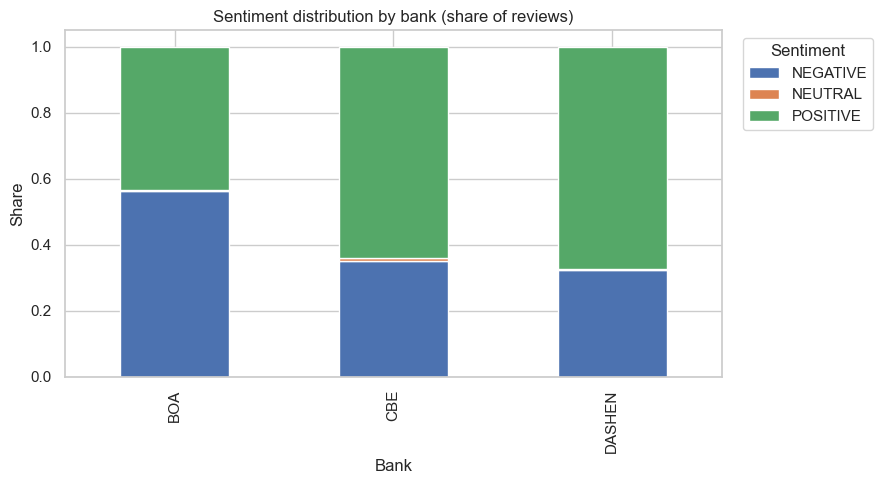

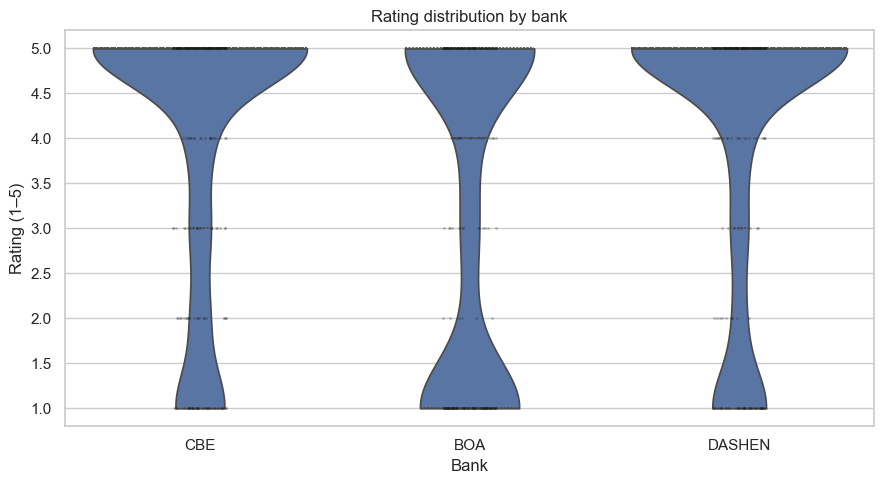

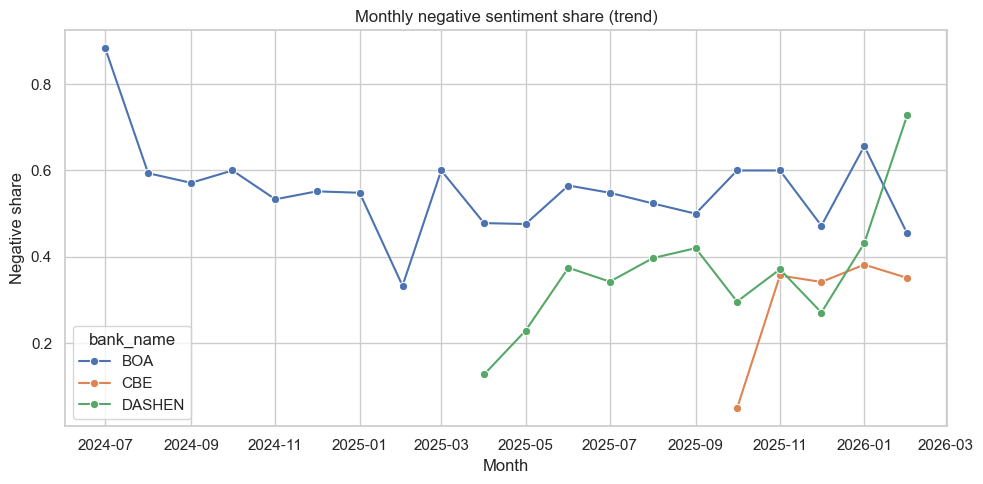

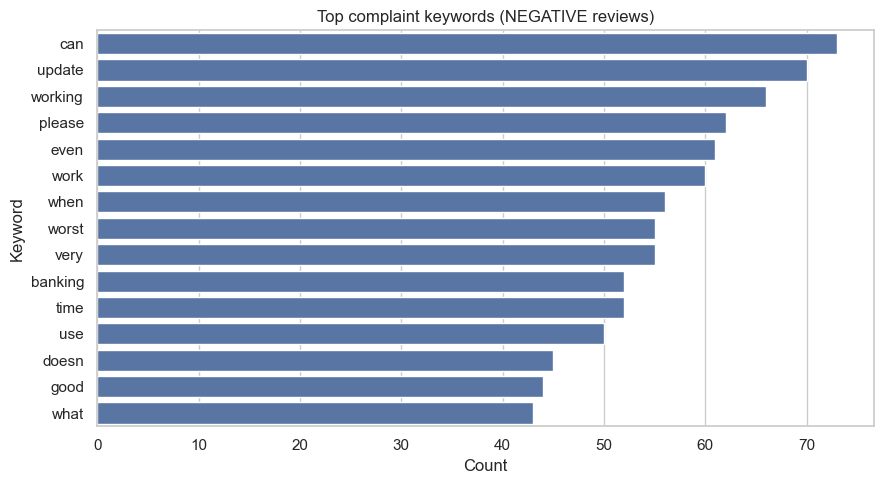

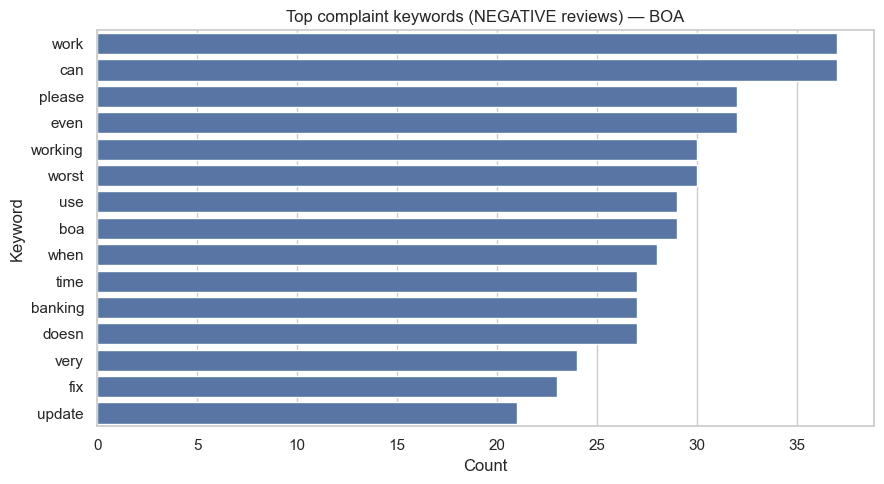

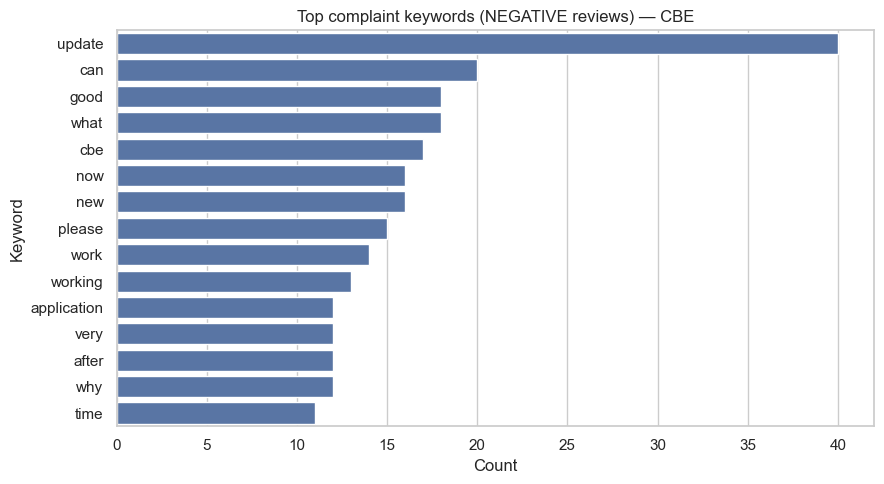

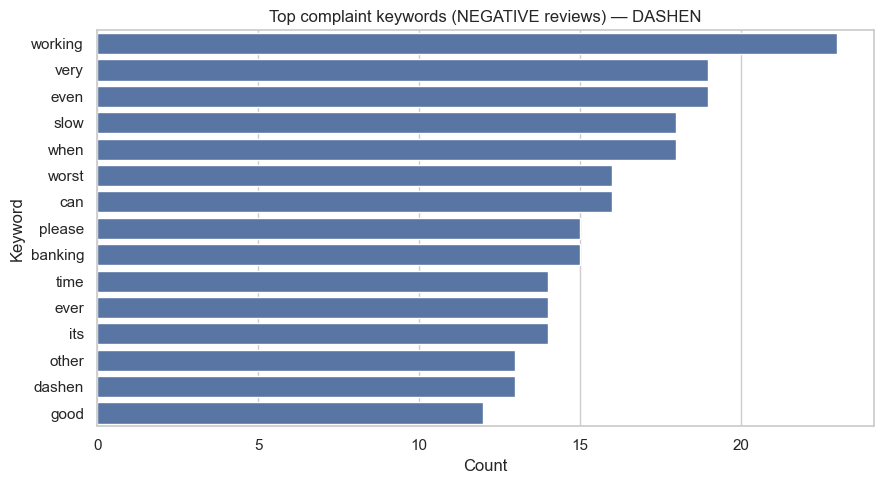

In [10]:
def plot_sentiment_by_bank(d: pd.DataFrame, outpath: Path):
    ctab = d.pivot_table(index='bank_name', columns='sentiment_label', values='review_id', aggfunc='count', fill_value=0)
    share = ctab.div(ctab.sum(axis=1), axis=0)
    cols = [c for c in ['NEGATIVE','NEUTRAL','POSITIVE'] if c in share.columns]
    ax = share[cols].plot(kind='bar', stacked=True, figsize=(9,5))
    ax.set_title('Sentiment distribution by bank (share of reviews)')
    ax.set_xlabel('Bank'); ax.set_ylabel('Share')
    ax.legend(title='Sentiment', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(); plt.savefig(outpath, dpi=200); plt.show()

def plot_rating_distribution(d: pd.DataFrame, outpath: Path):
    plt.figure(figsize=(9,5))
    sns.violinplot(data=d, x='bank_name', y='rating', inner='quartile', cut=0)
    s = d.dropna(subset=['rating'])
    if len(s) > 800: s = s.sample(800, random_state=7)
    sns.stripplot(data=s, x='bank_name', y='rating', color='k', alpha=0.25, size=2)
    plt.title('Rating distribution by bank'); plt.xlabel('Bank'); plt.ylabel('Rating (1–5)')
    plt.tight_layout(); plt.savefig(outpath, dpi=200); plt.show()

def plot_negative_trend_monthly(d: pd.DataFrame, outpath: Path):
    dd = d.dropna(subset=['review_date']).copy()
    if dd.empty:
        print('No usable review_date values for trend plot.'); return
    dd['month'] = dd['review_date'].dt.to_period('M').dt.to_timestamp()
    dd['is_negative'] = (dd['sentiment_label'] == 'NEGATIVE').astype(int)
    g = dd.groupby(['bank_name','month'], as_index=False).agg(n=('review_id','count'), neg_share=('is_negative','mean'))
    plt.figure(figsize=(10,5))
    sns.lineplot(data=g, x='month', y='neg_share', hue='bank_name', marker='o')
    plt.title('Monthly negative sentiment share (trend)'); plt.xlabel('Month'); plt.ylabel('Negative share')
    plt.tight_layout(); plt.savefig(outpath, dpi=200); plt.show()

def plot_top_negative_keywords(d: pd.DataFrame, outpath: Path, bank_name: str | None = None, topn: int = 15):
    dd = d.copy()
    if bank_name: dd = dd[dd['bank_name'] == bank_name]
    dd = dd[dd['sentiment_label'] == 'NEGATIVE']
    counts = top_keywords(dd['review_text'], topn=topn)
    if not counts:
        print('No keywords found for', bank_name or 'ALL'); return
    words, vals = zip(*counts)
    plt.figure(figsize=(9,5))
    sns.barplot(x=list(vals), y=list(words), color='#4c72b0')
    title = 'Top complaint keywords (NEGATIVE reviews)' + (f' — {bank_name}' if bank_name else '')
    plt.title(title); plt.xlabel('Count'); plt.ylabel('Keyword')
    plt.tight_layout(); plt.savefig(outpath, dpi=200); plt.show()

plot_sentiment_by_bank(df, FIG_DIR / 'sentiment_by_bank.png')
plot_rating_distribution(df, FIG_DIR / 'rating_distribution.png')
plot_negative_trend_monthly(df, FIG_DIR / 'negative_trend_monthly.png')
plot_top_negative_keywords(df, FIG_DIR / 'top_negative_keywords_overall.png')
for b in banks:
    safe = b.lower().replace(' ','_')
    plot_top_negative_keywords(df, FIG_DIR / f'top_negative_keywords_{safe}.png', bank_name=b)


## 8) Generate the final report (Markdown)

In [11]:
def render_report_markdown(d, drivers, pains, bank_kpis):
    figdir = 'figures'
    lines = []
    lines.append('# Task 4 — Insights and Recommendations (Mobile Banking App Reviews)\n')
    lines.append('## 1. Executive Summary\n')
    lines.append(textwrap.dedent(f'''\
    This report analyzes customer reviews for mobile banking apps using **ratings**, **sentiment labels/scores**, and **themes** (`theme_primary`).
    It identifies **drivers** of positive experience and **pain points** behind negative sentiment for each bank, compares banks, and proposes actionable improvements.

    **Dataset size:** {len(d):,} reviews (PostgreSQL).
    ''').strip() + '\n')
    lines.append('\n## 2. Cross-bank comparison (KPIs)\n')
    lines.append(bank_kpis.to_markdown(index=False))
    lines.append('\n\n## 3. Visualizations\n')
    lines.append(f"- `{figdir}/sentiment_by_bank.png` — Sentiment distribution by bank")
    lines.append(f"- `{figdir}/rating_distribution.png` — Rating distribution by bank")
    lines.append(f"- `{figdir}/negative_trend_monthly.png` — Monthly negative sentiment share")
    lines.append(f"- `{figdir}/top_negative_keywords_overall.png` — Top complaint keywords")
    lines.append('\n\n## 4. Bank-level insights and recommendations\n')
    for b in sorted(d['bank_name'].unique().tolist()):
        lines.append(f"\n### {b}\n")
        dsub = drivers[drivers['bank_name']==b]
        psub = pains[pains['bank_name']==b]
        lines.append('#### Drivers (2+)\n')
        lines.append(dsub.to_markdown(index=False) if not dsub.empty else '_No driver themes met threshold._')
        if not dsub.empty:
            for _, row in dsub.iterrows():
                theme = row['theme_primary']
                snips = sample_snippets(d, b, theme, kind='DRIVER', n_snips=2)
                if snips:
                    lines.append(f"\nEvidence snippets for **{theme}**:")
                    for s in snips: lines.append(f"- \"{s}\"")
        lines.append('\n#### Pain points (2+)\n')
        lines.append(psub.to_markdown(index=False) if not psub.empty else '_No pain themes met threshold._')
        if not psub.empty:
            for _, row in psub.iterrows():
                theme = row['theme_primary']
                snips = sample_snippets(d, b, theme, kind='PAIN_POINT', n_snips=2)
                if snips:
                    lines.append(f"\nEvidence snippets for **{theme}**:")
                    for s in snips: lines.append(f"- \"{s}\"")
        pain_themes = psub['theme_primary'].tolist() if not psub.empty else []
        recs = recommendations_from_pain_themes(pain_themes)
        lines.append('\n#### Recommendations (2+)\n')
        for i, r in enumerate(recs, 1): lines.append(f"{i}. {r}")
        safe = b.lower().replace(' ','_')
        lines.append(f"\nAdditional keywords figure: `{figdir}/top_negative_keywords_{safe}.png`")
    lines.append('\n\n## 5. Ethics and limitations\n')
    lines.append(textwrap.dedent('''\
    - **Review selection bias:** Reviewers are self-selected; negative experiences are often overrepresented.
    - **Event/release bias:** A single outage or app release can spike negative reviews temporarily.
    - **Platform bias:** Store reviews may not represent all customers or device/network contexts.
    - **Language + NLP limitations:** Mixed language, spelling variation, and short texts reduce sentiment/theme accuracy.
    - **Attribution caution:** Themes reflect user perception and should be validated with operational logs.
    ''').strip())
    return '\n'.join(lines)

report_md = render_report_markdown(df, drivers, pains, bank_kpis)
path = OUT_DIR / 'task4_report.md'
path.write_text(report_md, encoding='utf-8')
print('Report written to:', path.resolve())


Report written to: D:\Python\Week 12\Customer-Experience-Analytics-for-Fintech-Apps-Updated\notebooks\reports\task4\task4_report.md


## 9) Minimum essential check

In [12]:
ok = True
for b in banks:
    dn = (drivers['bank_name']==b).sum(); pn = (pains['bank_name']==b).sum()
    print(f"{b}: drivers={dn}, pains={pn}")
    ok = ok and (dn >= 1) and (pn >= 1)
figs = list(FIG_DIR.glob('*.png'))
print('Saved figures:', len(figs))
if not ok:
    raise AssertionError('Minimum essential not met. Lower MIN_N (e.g., 8) and rerun from Insights.')
if len(figs) < 2:
    raise AssertionError('Minimum essential not met: fewer than 2 plots saved.')
print('[OK] Minimum essential satisfied.')


BOA: drivers=2, pains=2
CBE: drivers=2, pains=2
DASHEN: drivers=2, pains=2
Saved figures: 7
[OK] Minimum essential satisfied.
